# Overview

In this analysis, we measure how well players convert an advantage, as measured by the computer evaluation.

For instance, we would expect a player to obtain roughly 50% of all available points if they have an equal position against a similarly-rated player. But this percentage will increase if they are higher-rated than their opponent.

I find that, if you are playing against someone who is 300 points lower-rated than you, and you are in a losing position (-2), then you're still expected to get more than 50% of points!

The impact of the rating on the win percentage is not strongly affected by player quality, the effects are similarly strong for a sample of strong players (Elo > 2000) and super tournaments.

# Setup

In [5]:
import pandas as pd
import numpy as np
import psycopg2
import pandas.io.sql as sqlio
import statsmodels.formula.api as smf
import imp

In [6]:
import queries
import functions as f
imp.reload(f); imp.reload(queries)

<module 'queries' from '/Users/cg/Dropbox/code/Python/chess-analysis/queries.py'>

In [7]:
pd.set_option('precision', 2) 
pd.set_option('display.width', 200)

%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [13]:
use_dev = False
connstring = f.CONNSTRING_DEV if use_dev else f.CONNSTRING_PROD
conn = psycopg2.connect(connstring)

# Data cleaning

We look only at moves between move 10 and 40 of a game. Thus we exclude moves in which most players are still in book and also long endgames which provide a lot of observations, but little change in the status of the game.

In [18]:
params = {
    'move_number_start': 10,
    'move_number_end': 40
}

In [24]:
df = sqlio.read_sql_query(queries.q_rating, conn, params=params) 
df.shape

(572665, 6)

## Summary statistics

### Number of observations 

In [25]:
df.db_name.value_counts()

kingbase_random                       532836
Rejkjavik Open 2018                    23716
Candidates 2011-2018                    5916
Wijk An Zee (Tata Steel) 2012-2018      5193
Supertournaments 2017                   4461
World Championships 1886-2014            543
Name: db_name, dtype: int64

In [26]:
df['difference'] = df.rating_own - df.rating_opponent 
df['result'] = df.win + 0.5 * df.draw

### Standard deviation of rating difference
The standard deviation is much smaller in elite tournaments than in opens:

In [27]:
df.groupby('db_name').difference.std()

db_name
Candidates 2011-2018                   35.01
Rejkjavik Open 2018                   321.70
Supertournaments 2017                  61.70
Wijk An Zee (Tata Steel) 2012-2018     87.20
World Championships 1886-2014          82.67
kingbase_random                       173.47
Name: difference, dtype: float64

## Data cleaning

Creating a grouped variable for the rating difference

In [28]:
df['difference_group'] = round(df.difference / 200)
diff_max = 3
df.loc[df.difference_group < -diff_max, 'difference_group'] = -diff_max
df.loc[df.difference_group > diff_max, 'difference_group'] = diff_max

df['eval_group'] = round(df.ev / 100)

# Summarizing the data

In [35]:
df_king = df.query('db_name == "kingbase_random"')

In [36]:
means = pd.DataFrame(
     df_king
    .query('-3 <= eval_group <= 3')
    .groupby(['difference_group', 'eval_group'])
    .result
    .mean()
)
counts = (df_king
  .query('-3 <= eval_group <= 3')
  .groupby(['difference_group', 'eval_group'])
  .result
  .count())

means['counts'] = counts  
means = means.query('counts >= 10 and difference_group >= 0')
del means['counts']

In [42]:
table = means.unstack(0) * 100 
table.index = [int(v) for v in table.index]
def group_name(v):
    return '%s to %s' % (v*200-100, v*200+100)
table.columns = [group_name(v) for v in table.columns.get_level_values(1)]

<AxesSubplot:title={'center':'Result percentage as function of evaluation and rating difference'}, xlabel='Evaluation', ylabel='Result percentage'>

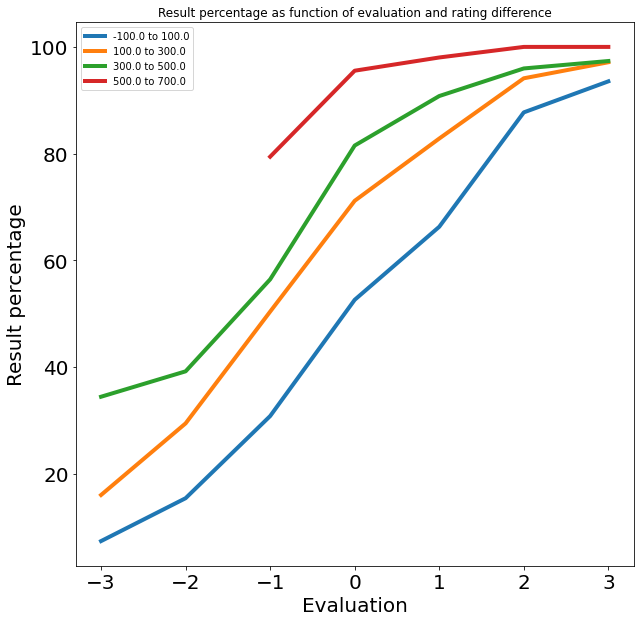

In [43]:
fig, ax = plt.subplots()
ax.set_xlabel("Evaluation", fontsize=20)
ax.set_ylabel("Result percentage", fontsize=20)
settings = {
    'title': "Result percentage as function of evaluation and rating difference",
    'fontsize': 20,
    'legend': True,
    'figsize': (10, 10),
    'lw': 4,
    'ax': ax
}
table.plot(**settings)

The graph shows the expected result percentage as a function of the position evaluation and the rating difference to the opponent.

For instance, we find that, if you play against someone who is 400 points lower-rated then you and your evaluation is -3, then you are still obtaining more than 40% of the points. This is among players with Elo above 2000.

Note, however, that this is just one point on this graph. To quantify this by summarizing all the data, we work with a linear regression, below. 

The same data in table format

In [44]:
table

,-100.0 to 100.0,100.0 to 300.0,300.0 to 500.0,500.0 to 700.0
-3,7.34,15.98,34.40,NaN
-2,15.38,29.41,39.17,NaN
-1,30.78,50.37,56.41,79.41
0,52.58,71.15,81.50,95.54
1,66.27,82.82,90.79,98.02
2,87.72,94.11,95.96,100.00
3,93.54,97.12,97.35,100.00


## Quantifying the rating-evaluation tradeoff
We know try to quantify these effects and calculate the tradeoff between player rating and the position evaluation. We do this using a linear regression.

Creating helper variables that are scaled, which gives us nicer regression coefficients.

In [45]:
df['rating_own_small'] = df.rating_own / 100
df['rating_opponent_small'] = df.rating_opponent / 100
df['diff_small'] = df.difference / 100
df['eval_small'] = df.ev / 100

In [47]:
df_king = df.query('db_name == "kingbase_random"')
reg = smf.ols('result ~ eval_small + diff_small', data=df_king.query('-5 <= eval_small <= 5')).fit()
params = reg.params
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 result   R-squared:                       0.362
Model:                            OLS   Adj. R-squared:                  0.362
Method:                 Least Squares   F-statistic:                 1.453e+05
Date:                Sat, 01 Jan 2022   Prob (F-statistic):               0.00
Time:                        12:55:14   Log-Likelihood:            -1.4711e+05
No. Observations:              511532   AIC:                         2.942e+05
Df Residuals:                  511529   BIC:                         2.943e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5119      0.000   1122.939      0.000       0.511       0.513
eval_small     0.1280      0.000    336.778      0.000       0.127       0.129
diff_small     0.0875      0.000    325.704      0.000       0.087       0.088
==============================================================================
Omnibus:                     7838.850   Durbin-Watson:                   0.076
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5068.977
Skew:                          -0.108   Prob(JB):                         0.00
Kurtosis:                       2.562   Cond. No.                         1.84
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

To check for a non-linear effect, I include a squared term in the regression. The coefficient is small.

In [50]:
reg = smf.ols('result ~ eval_small + I(eval_small*eval_small) + diff_small', data=df_king.query('-5 <= eval_small <= 5')).fit()
params = reg.params
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 result   R-squared:                       0.362
Model:                            OLS   Adj. R-squared:                  0.362
Method:                 Least Squares   F-statistic:                 9.687e+04
Date:                Sat, 01 Jan 2022   Prob (F-statistic):               0.00
Time:                        12:55:38   Log-Likelihood:            -1.4709e+05
No. Observations:              511532   AIC:                         2.942e+05
Df Residuals:                  511528   BIC:                         2.942e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      0.5129      0.000   1038.282      0.000       0.512       0.514
eval_small                     0.1281      0.000    336.586      0.000       0.127       0.129
I(eval_small * eval_small)    -0.0007      0.000     -5.364      0.000      -0.001      -0.000
diff_small                     0.0875      0.000    325.726      0.000       0.087       0.088
==============================================================================
Omnibus:                     7840.481   Durbin-Watson:                   0.076
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5098.351
Skew:                          -0.110   Prob(JB):                         0.00
Kurtosis:                       2.564   Cond. No.                         4.33
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [51]:
value_of_100_rating = params['diff_small'] / params['eval_small']
print("Value of 100 rating points: %0.2f" % value_of_100_rating)

Value of 100 rating points: 0.68


In [52]:
df_value = pd.DataFrame()
df_value['rating_difference'] = np.arange(0, 400, 100)
df_value['evaluation'] = -(df_value.rating_difference * value_of_100_rating)/100

### Evaluation to get result of 50% against a player
Note that this is a linear interpolation from the linear regression.

In [55]:
df_value.set_index('rating_difference')

,evaluation
rating_difference,
0,-0.00
100,-0.68
200,-1.37
300,-2.05


# Comparison to super-tournaments

In [57]:
df_super = df.query('db_name == "Supertournaments 2017"')
reg_super = smf.ols('result ~ eval_small + diff_small', data=df_super.query('-5 <= eval_small <= 5')).fit()
params_super = reg_super.params
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 result   R-squared:                       0.362
Model:                            OLS   Adj. R-squared:                  0.362
Method:                 Least Squares   F-statistic:                 9.687e+04
Date:                Sat, 01 Jan 2022   Prob (F-statistic):               0.00
Time:                        12:56:34   Log-Likelihood:            -1.4709e+05
No. Observations:              511532   AIC:                         2.942e+05
Df Residuals:                  511528   BIC:                         2.942e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      0.5129      0.000   1038.282      0.000       0.512       0.514
eval_small                     0.1281      0.000    336.586      0.000       0.127       0.129
I(eval_small * eval_small)    -0.0007      0.000     -5.364      0.000      -0.001      -0.000
diff_small                     0.0875      0.000    325.726      0.000       0.087       0.088
==============================================================================
Omnibus:                     7840.481   Durbin-Watson:                   0.076
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5098.351
Skew:                          -0.110   Prob(JB):                         0.00
Kurtosis:                       2.564   Cond. No.                         4.33
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [60]:
value_of_100_rating = params['diff_small'] / params['eval_small']
print("Value of 100 rating points (Kingbase): %0.2f" % value_of_100_rating)

Value of 100 rating points (Kingbase): 0.68


In [61]:
value_of_100_rating = params_super['diff_small'] / params_super['eval_small']
print("Value of 100 rating points (Supertournaments): %0.2f" % value_of_100_rating)

Value of 100 rating points (Supertournaments): 0.59


For elite players, the impact of rating on the result percentage is only a little smaller (0.6 vs 0.7) compared to a sample of games from players with rating above 2000 (Kingbase).